# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Read data

## Define paths

In [2]:
DRIVE_PATH = "./data"
DATA_PATH = DRIVE_PATH + "/original"
PREPROCESSED_PATH = DRIVE_PATH + "/preprocessed"

os.listdir(DATA_PATH)

['economic_policy.csv',
 'education.csv',
 'environment.csv',
 'financial_sector.csv',
 'health2005_1981.csv',
 'healthdo2006.csv',
 'infrastructure.csv',
 'population_mortality.csv',
 'public_private_sector.csv',
 'social_sector.csv']

## Split datasets into topics

In [3]:
DATASETES_TOPICS = {
    "economic": ["economic_policy", "financial_sector", "public_private_sector"],
    "health": ["population_mortality", "health"],
    "social": ["environment", "infrastructure", "education", "social_sector"],
}

## Some utils stuff

In [4]:
COUNTRY_NAME = "Country Name"
COUNTRY_CODE = "Country Code"
FEATURE_NAME = "Series Name"
FEATURE_CODE = "Series Code"

NOT_YEAR_COLUMNS = [COUNTRY_NAME, COUNTRY_CODE, FEATURE_NAME, FEATURE_CODE]

def year_col(year: int):
  return f"{year} [YR{year}]"

## Load data

In [5]:
# load datasets
raw_datasets = {
    name.split(".")[0]: pd.read_csv(f"{DATA_PATH}/{name}") 
    for name in os.listdir(DATA_PATH)
}

f"Loaded datasets: {len(raw_datasets)}"

'Loaded datasets: 10'

In [6]:
# merge healthdo2006 and health2005_1981 (replace them in raw_datasets by result of merge)
_health_dataset = raw_datasets["health2005_1981"]
_new_columns = [year_col(year) for year in range(2006, 2022)]
_health_dataset[_new_columns] = raw_datasets["healthdo2006"][_new_columns]

raw_datasets["health"] = _health_dataset
del raw_datasets["health2005_1981"]
del raw_datasets["healthdo2006"]

print(f"Actual datasets: {len(raw_datasets)}")

raw_datasets["health"]

Actual datasets: 9


,Country Name,Country Code,Series Name,Series Code,1981 [YR1981],1982 [YR1982],1983 [YR1983],1984 [YR1984],1985 [YR1985],1986 [YR1986],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Argentina,ARG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,76.117,73.752,73.396,73.031,72.536,71.527,...,68.719,69.167,67.791,65.395,61.852,57.783,51.029,46.153,39.866,..
1,Argentina,ARG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,6.47552296063439,9.59615604621897,8.65832496118367,8.3459768371011,7.63430725730443,7.80040264019792,...,5.7817442068501,6.05291843670451,6.71270351428559,5.1566859021408,6.26456582010254,5.23162237725058,4.53787889681146,5.3185559967348,6.12846695022316,7.13154104672929
2,Argentina,ARG,Births attended by skilled health staff (% of ...,SH.STA.BRTC.ZS,..,..,..,..,..,..,...,98.2,97,99.6,99.6,98.4,93.9,99.5,99.6,98.8,..
3,Argentina,ARG,"Contraceptive prevalence, any method (% of mar...",SP.DYN.CONU.ZS,..,..,..,..,..,..,...,..,72.4,..,..,..,..,..,..,70.1,..
4,Argentina,ARG,Domestic credit provided by financial sector (...,FS.AST.DOMS.GD.ZS,48.4498895498259,45.9987644434275,46.2096995159375,41.748912658676,32.5730009425071,32.8696858004227,...,30.6012215884466,33.1873915714789,34.4321395694616,40.4276279370297,37.9322482578709,38.8683983871173,..,..,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81665,Data from database: World Development Indicators,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Quick actions..

In [7]:
# replace ".." with NaN...
for dataset in raw_datasets.values():
  dataset[dataset == ".."] = np.nan

In [8]:
# remove rows with NaN as country or series
for dataset in raw_datasets.values():
  dataset.drop(dataset.loc[dataset[COUNTRY_NAME].isna()].index, inplace=True)
  dataset.drop(dataset.loc[dataset[FEATURE_NAME].isna()].index, inplace=True)

In [9]:
DATASETS_NAMES = list(raw_datasets.keys())

# Preprocess data

Objective: we want to have such data that:

- all countries have the same features

- each value is not Nan

- we have as many countries and as many features as possible


Steps:

- remove rows that have the most undefined data - this may result in countries not having the same features

- if some rows have only some undefined values, fill them with a moving average

- check which features are most common and remove countries that do not have these features

- now we have countries that have many features common - but we need to remove those features that are not common


## Another utils stuff (for datasets describing)

In [10]:
# count nan values utils
def get_years(dataset: pd.DataFrame):
  return sorted(set(dataset.columns).difference(NOT_YEAR_COLUMNS))


def get_countries(dataset: pd.DataFrame):
  return set(dataset[COUNTRY_NAME])


def get_country_codes(dataset: pd.DataFrame):
  return set(dataset[COUNTRY_CODE])


def get_features(dataset: pd.DataFrame):
  return set(dataset[FEATURE_NAME])


def nan_data_per_year(dataset: pd.DataFrame):
  return {
      y: dataset[y].isna().sum() / len(dataset.index) 
      for y in get_years(dataset)
  }

In [11]:
def features_per_country(dataset: pd.DataFrame):
  """Returns number of features of each country, as dict {country: number of features}"""
  return {
      c: len(get_features(dataset.loc[dataset[COUNTRY_NAME] == c]))
      for c in get_countries(dataset)
  }


def features_of_countries(dataset: pd.DataFrame):
  """Returns features of each country, as dict {country: features}"""
  return {
      c: get_features(dataset.loc[dataset[COUNTRY_NAME] == c])
      for c in get_countries(dataset)
  }

In [12]:
def plot_histograms(datasets: dict[str, pd.DataFrame], func, title: str):
  """func(dataset) should return dict {str: number}, this values are used to plot histogram"""
  fig, axs = plt.subplots(3, 3, figsize=(30, 30))
  fig.suptitle(title)
  for ax, (name, dataset) in zip(axs.flatten(), datasets.items()):
    hist = func(dataset)
    ax.bar(hist.keys(), hist.values())
    ax.set_title(name)
    ax.tick_params(labelrotation=90)
  plt.show()


def plot_sorted(datasets: dict[str, pd.DataFrame], func, title: str):
  """Similar to plot_histograms, but values are sorted before plot"""
  fig, axs = plt.subplots(9, 1, figsize=(60, 60))
  fig.suptitle(title)
  for ax, (name, dataset) in zip(axs.flatten(), datasets.items()):
    hist = sorted([item for item in func(dataset).items()], key=lambda item: item[1])
    x, y = [k for k, _ in hist], [v for _, v in hist]
    ax.bar(x, y)
    ax.set_yticks(np.arange(0, max(y), step=max(y) // 10))
    ax.set_title(name)
    ax.tick_params(labelrotation=90)
  plt.show()

## Select time range of data

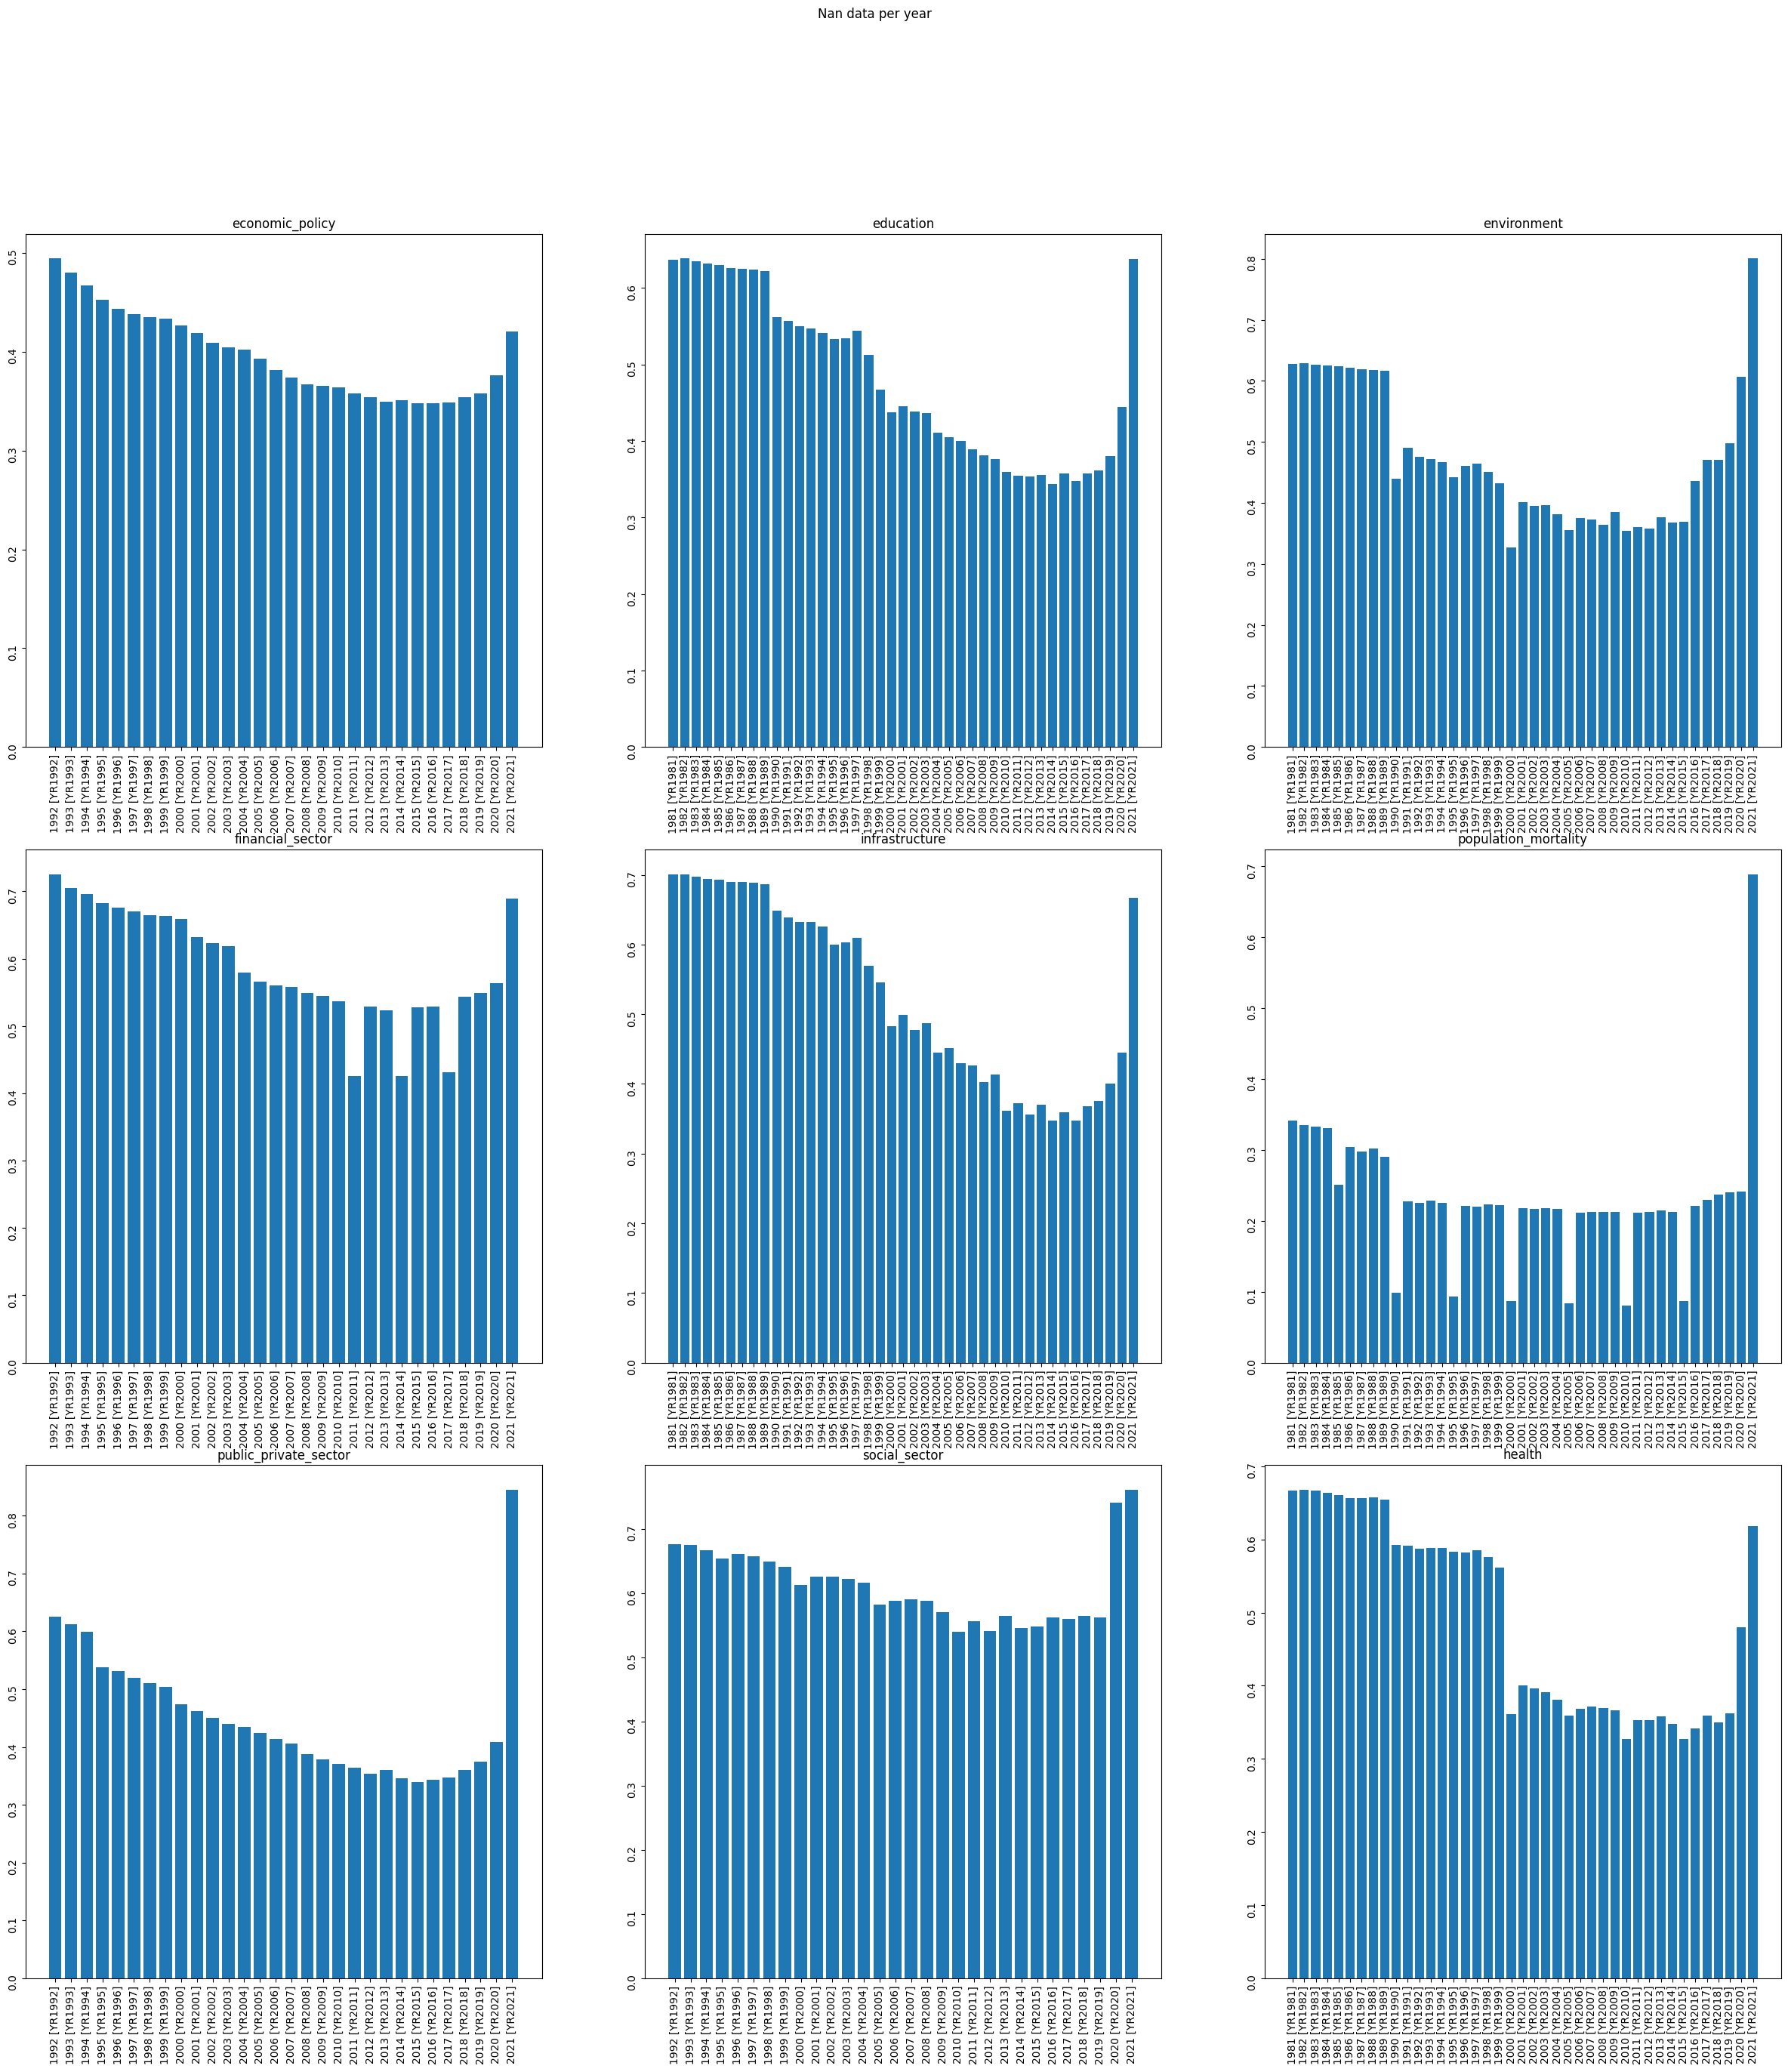

In [13]:
plot_histograms(raw_datasets, nan_data_per_year, "Nan data per year")


The graph above shows that:
- Some datasets only have data from 1992
- in datasets "financial_sector", "infrastructure", "education", "envionment", and "health" we see a significant decrease in undefined values  **(A co z public_private_sector?)**
- every dataset expect "environment" has least undefined values in years from 2010 to 2019 **(a population_mortiality)?**
- we see significant increase in undefined values in 2020 for every dataset

We decided to take data since 1992.

In the case of missing data for the years 2020-2021, we will reject them or try to estimate them.

In [14]:
def leave_years(dataset: pd.DataFrame, from_year: int, to_year: int = 2022):
  cols = NOT_YEAR_COLUMNS + [year_col(y) for y in range(from_year, to_year)]
  return dataset[cols]

from_1992_datasets = {name: leave_years(dataset, 1992) for name, dataset in raw_datasets.items()}

## Delete very undefined data

In [15]:
def remove_nan_rows(dataset: pd.DataFrame, maximal_nans_in_sequence: int, maximal_nans_in_row: float):
  """
  If any row in the dataset has too many Nan values, it deletes that row

  Parametewrs:
    dataset: to clean up
    maximal_nans_in_sequence: if there is more Nan values in sequence, this row will be removed
    maximal_nans_in_row: if the nan values make up more of the row than this value, this row will be removed

  Returns:
    cleaned dataset
  """
  data = dataset.loc[:,~dataset.columns.isin(NOT_YEAR_COLUMNS)]
  threshold = len(data.columns)*maximal_nans_in_row
  nan_seq = []
  for _, row in data.iterrows():
      nan_sequence = pd.isnull(row.values)
      if nan_sequence.sum() > threshold:
        nan_seq.append(True)
      else:
        nan_sequence_rolling = np.convolve(nan_sequence, np.ones(maximal_nans_in_sequence, dtype=int), mode='valid')
        has_nan_sequence = any(nan_sequence_rolling > maximal_nans_in_sequence-1)
        nan_seq.append(has_nan_sequence)
  return dataset.drop(dataset.loc[nan_seq].index)

In [16]:
from_1992_datasets_cleaned = {name: remove_nan_rows(dataset, 2, 0.2) for name, dataset in from_1992_datasets.items()}

In [17]:
# number of countries per dataset
for name, dataset in from_1992_datasets_cleaned.items():
    print(f"{len(get_countries(dataset))} countires in {name} dataset")

247 countires in economic_policy dataset
265 countires in education dataset
265 countires in environment dataset
248 countires in financial_sector dataset
265 countires in infrastructure dataset
265 countires in population_mortality dataset
246 countires in public_private_sector dataset
265 countires in social_sector dataset
265 countires in health dataset


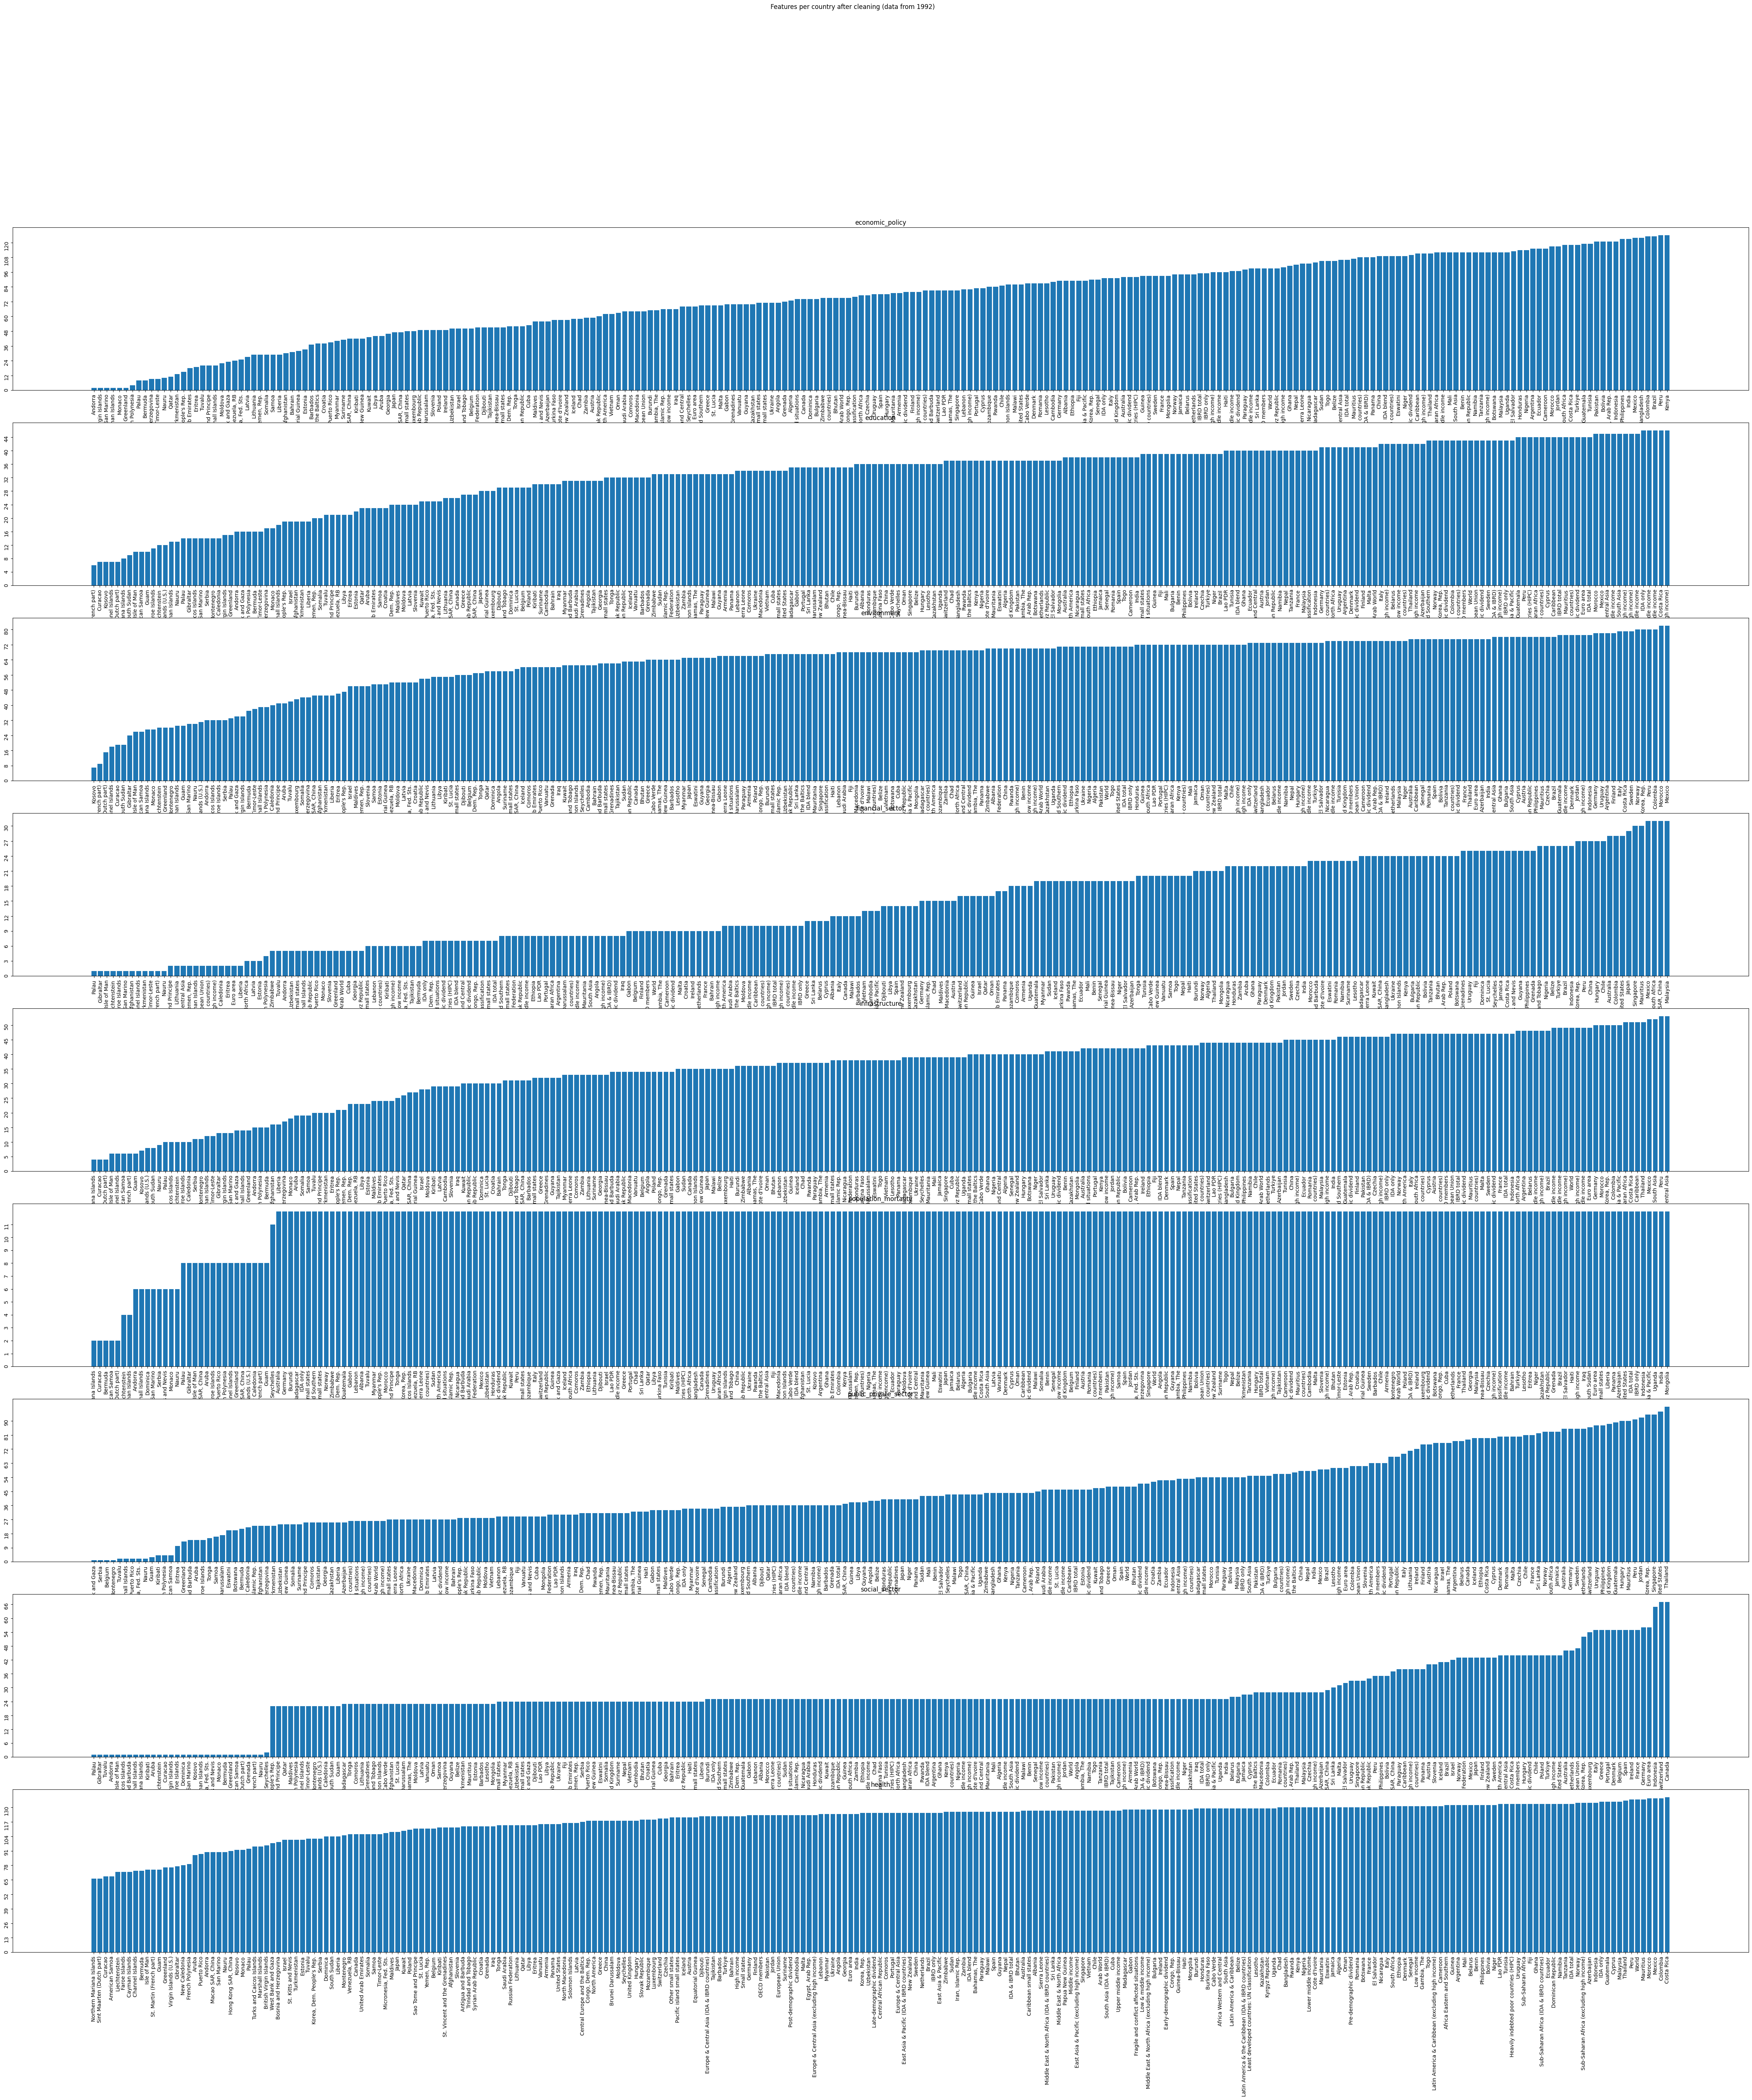

In [18]:
plot_sorted(from_1992_datasets_cleaned, features_per_country, "Features per country after cleaning (data from 1992)")

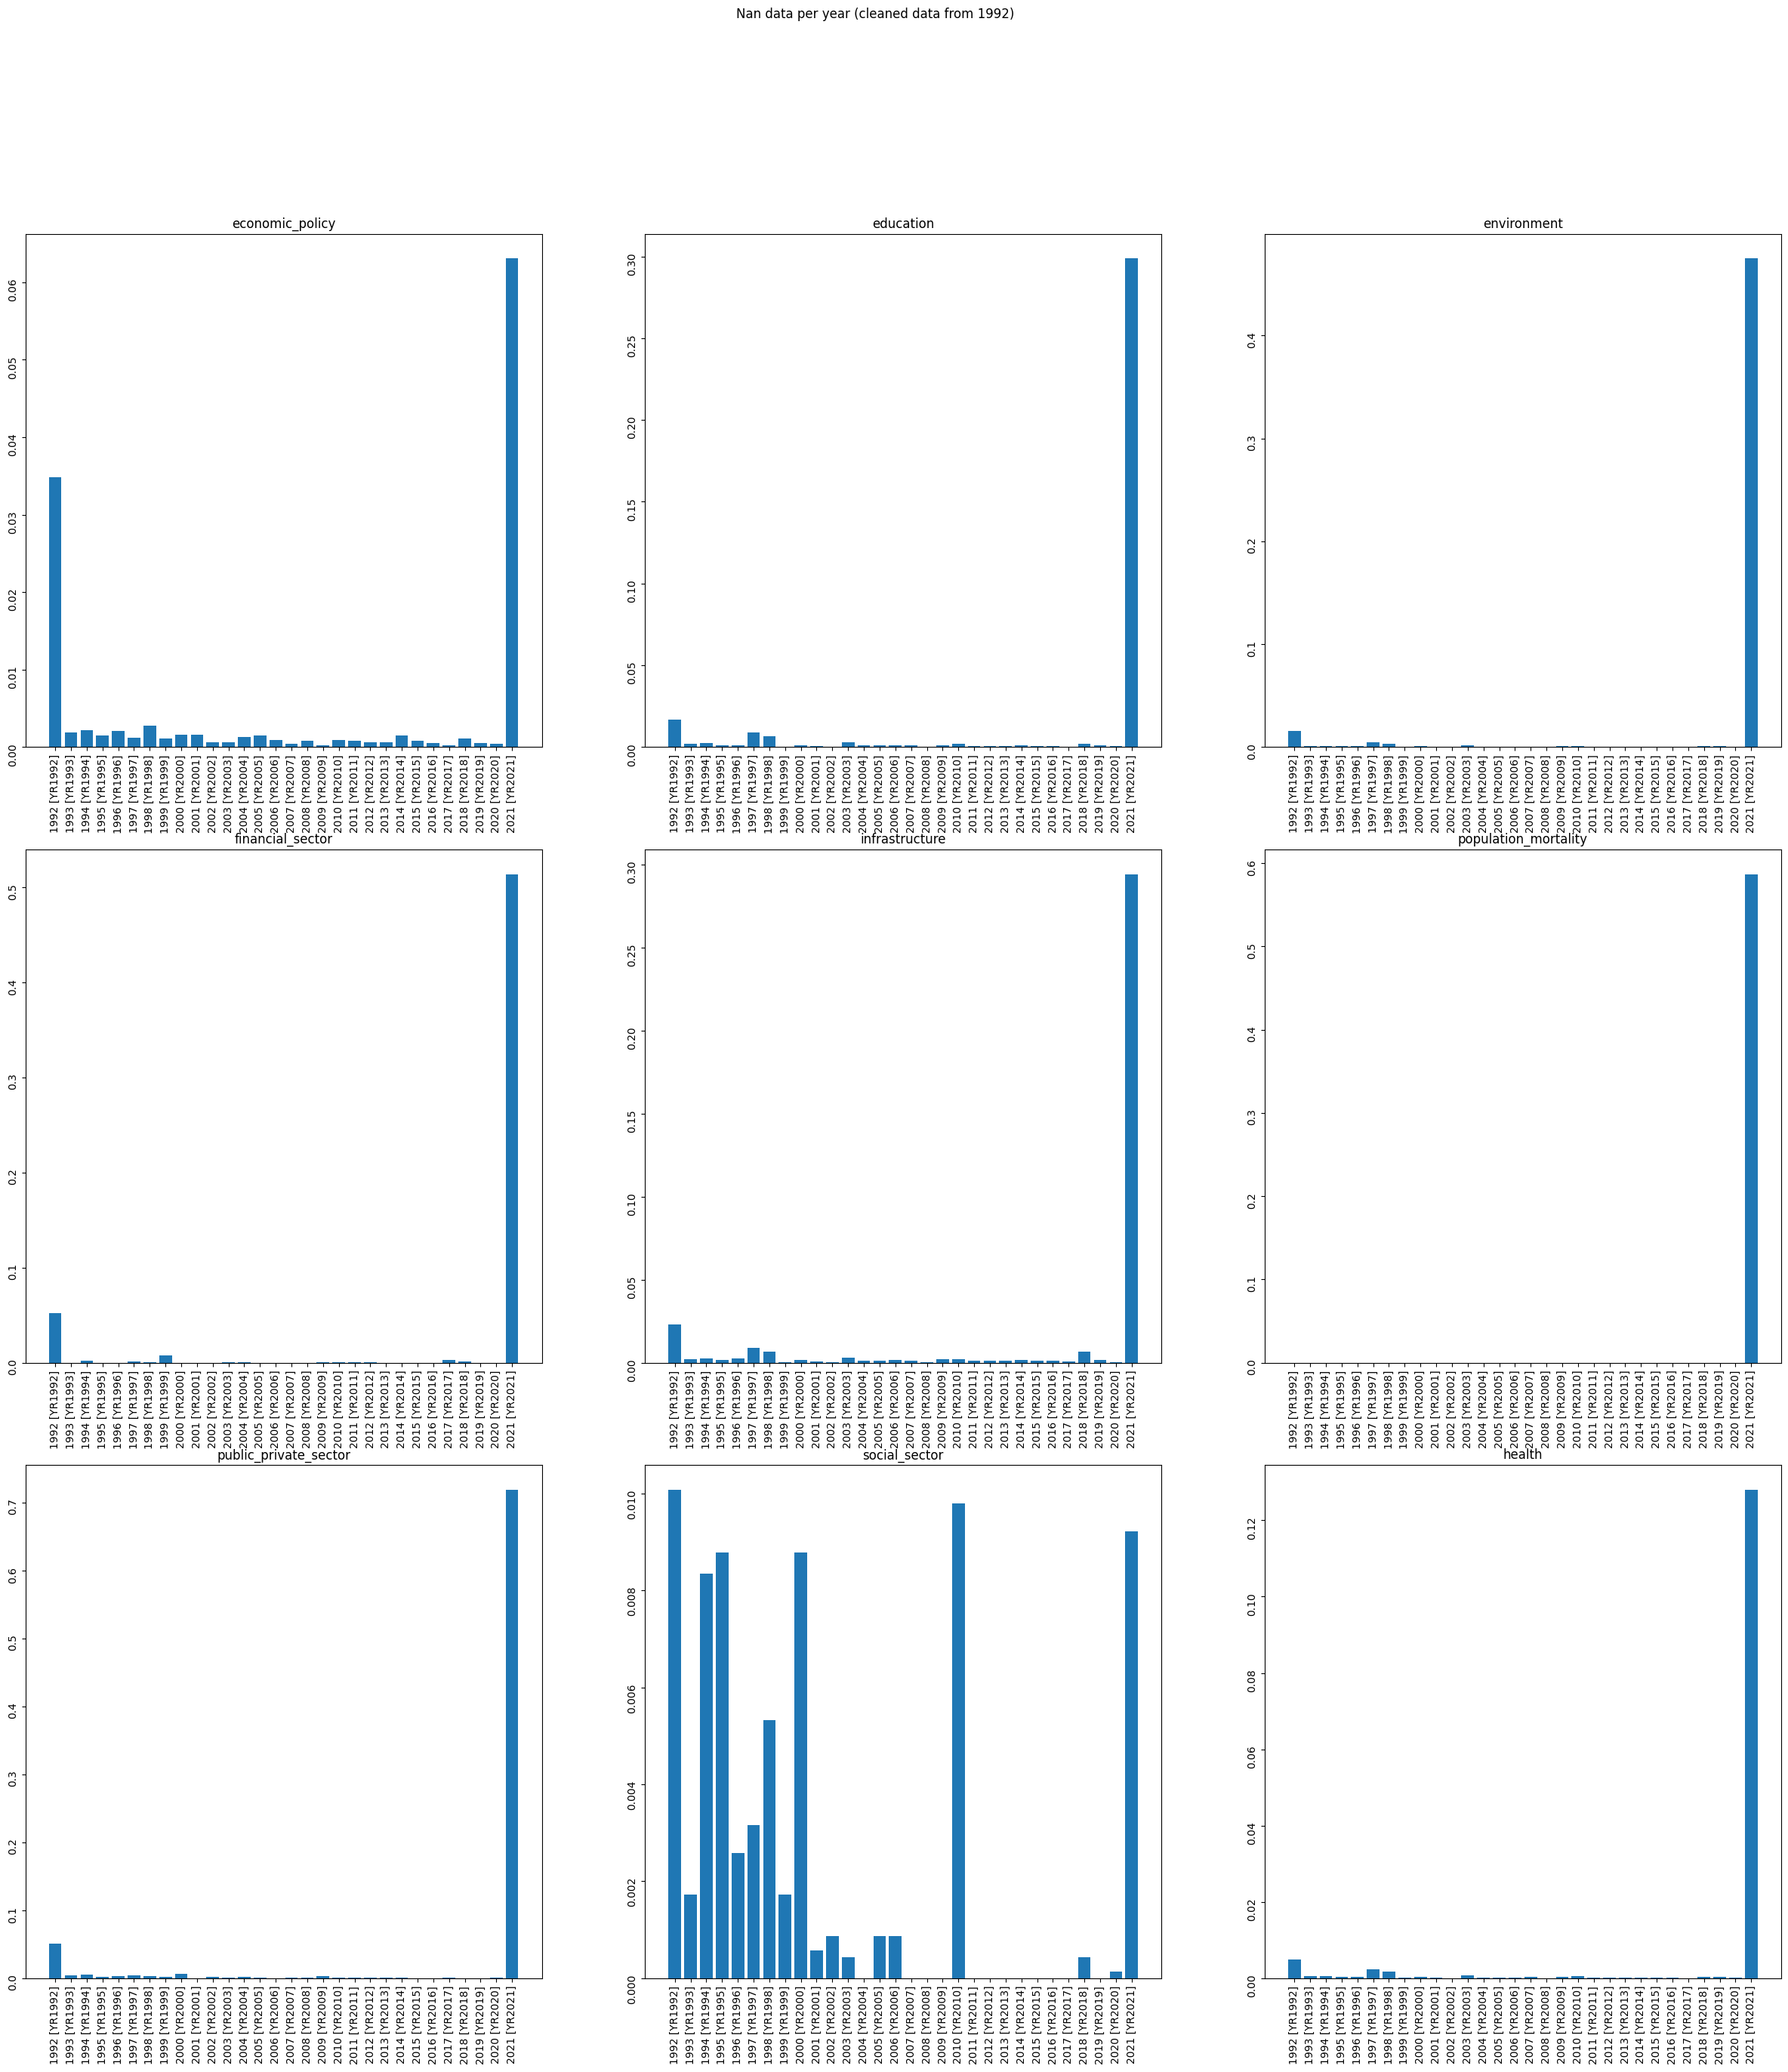

In [19]:
plot_histograms(from_1992_datasets_cleaned, nan_data_per_year, "Nan data per year (cleaned data from 1992)")

## Fill Nan values

In [20]:
def fill_nans(dataset: pd.DataFrame):
  """Fills the Nan values in the rows with a moving average"""
  filling = lambda row: row.fillna(row.rolling(5, min_periods=1,center=True).mean()) if any(pd.isnull(row)) else row
  filled = dataset.copy()
  years = ~filled.columns.isin(NOT_YEAR_COLUMNS)
  filled.loc[:, years] = filled.loc[:, years].apply(filling, axis=1)
  return filled

In [21]:
from_1992_datasets_final = {name: fill_nans(dataset) for name, dataset in from_1992_datasets_cleaned.items()}

In [22]:
# number of nans per dataset
for name, dataset in from_1992_datasets_final.items():
    print(f"{dataset.isna().sum().sum()} nan values in {name} dataset")

0 nan values in economic_policy dataset
0 nan values in education dataset
0 nan values in environment dataset
0 nan values in financial_sector dataset
0 nan values in infrastructure dataset
0 nan values in population_mortality dataset
0 nan values in public_private_sector dataset
0 nan values in social_sector dataset
0 nan values in health dataset


## Merge data into topics

In [23]:
def merge_datasets(datasets: list[pd.DataFrame]):
  """Concatinate datasets and removes dumplcates (some datasets might have same features...)"""
  result = datasets[0].copy()
  for ds in datasets[1:]:
    result = pd.concat([result, ds], ignore_index=True)
  return result.drop_duplicates()


raw_topic_datasets = {}
for topic_name, datasets_names in DATASETES_TOPICS.items():
  topics_datasets = [from_1992_datasets_final[name] for name in datasets_names]
  merged = merge_datasets(topics_datasets)
  raw_topic_datasets[topic_name] = merged

## Drop countries without most common features

In [24]:
def features_counts(dataset: pd.DataFrame):
  """Returns sorted list of tuples of (feature name, number of countries that have this feature)"""
  features = features_of_countries(dataset)
  all_features = [f for features in features.values() for f in features]
  features_set = set(all_features)
  features_counts = [
      (f1, sum([f2 == f1 for f2 in all_features]))
      for f1 in features_set
  ]
  return sorted(features_counts, key=lambda f_count: f_count[1], reverse=True)

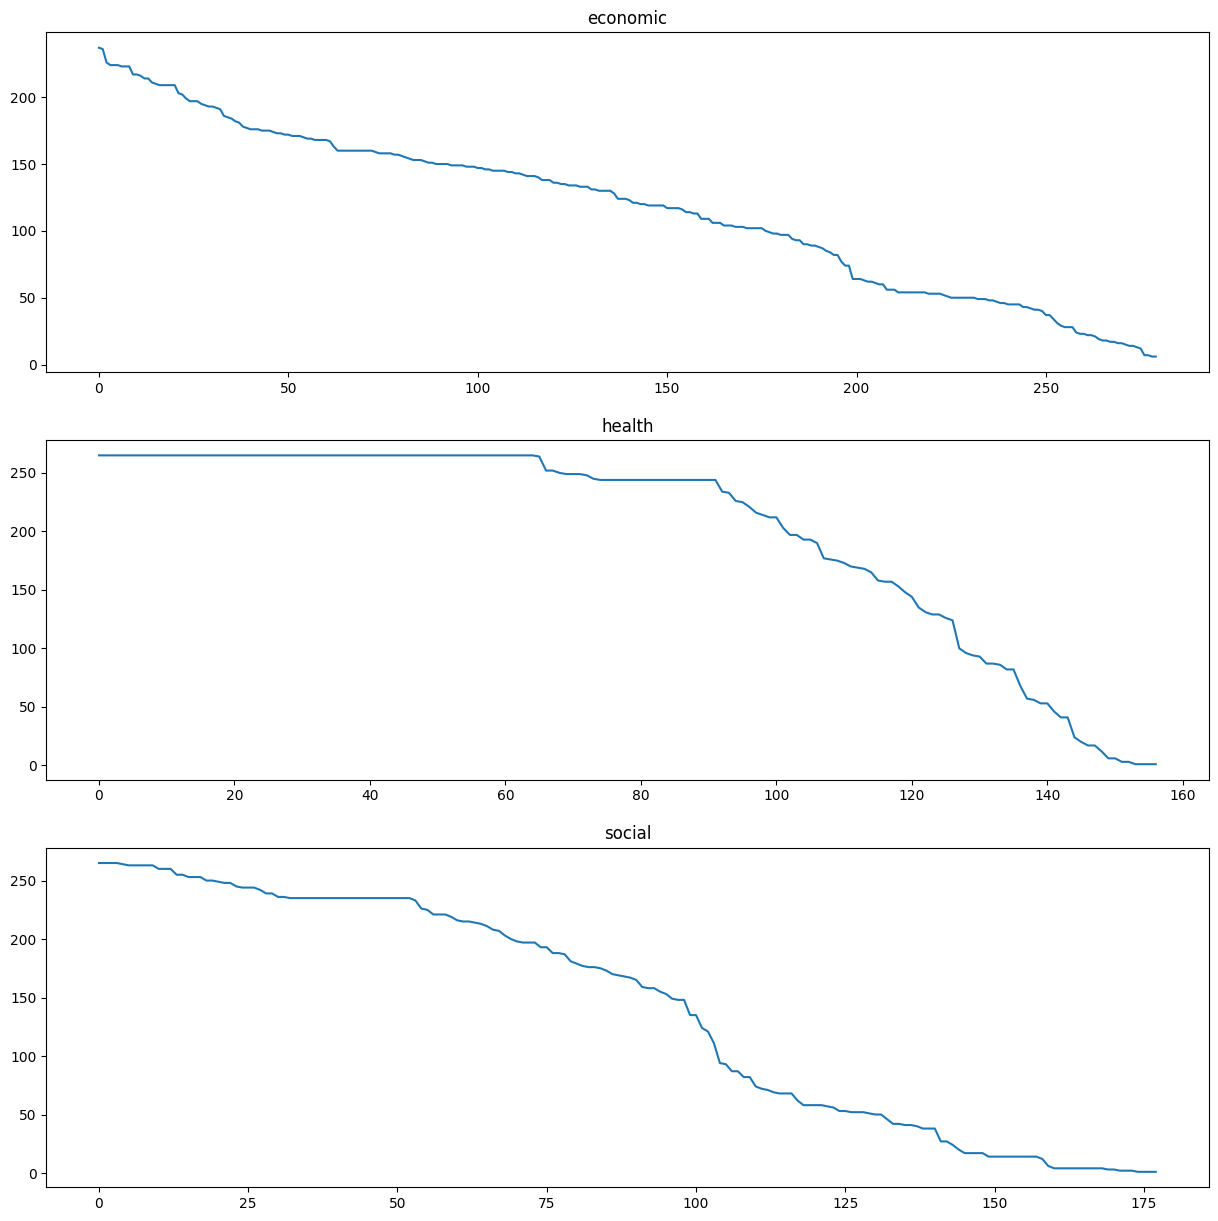

In [25]:
topics_features_counts = {topic: features_counts(ds) for topic, ds in raw_topic_datasets.items()}

_, ax = plt.subplots(len(raw_topic_datasets), 1, figsize=(15, 15))

for i, (topic, counts) in enumerate(topics_features_counts.items()):
  ax[i].plot([c[1] for c in counts])
  ax[i].set_title(topic)
plt.show()

In [26]:
def drop_countries_without_features(dataset: pd.DataFrame, must_have_features: set[str]):
  """Removes countries that do not have specified features"""
  for country, features in features_of_countries(dataset).items():
    if any(must_have_features.difference(features)):
      dataset = dataset.drop(dataset[dataset[COUNTRY_NAME] == country].index)
  return dataset

In [27]:
_first_n_features = lambda fc, n: {f for f, _ in fc[:n]}

# number of features to leave selected arbitrarily
topics_with_selected_countries = {
    "economic": drop_countries_without_features(raw_topic_datasets["economic"], _first_n_features(topics_features_counts["economic"], 30)),
    "health": drop_countries_without_features(raw_topic_datasets["health"], _first_n_features(topics_features_counts["health"], 62)),
    "social": drop_countries_without_features(raw_topic_datasets["social"], _first_n_features(topics_features_counts["social"], 52)),
}

# Remove not common features

In [28]:
def common_features(dataset: pd.DataFrame):
  """Returns set of features, that every country has"""
  common_features = set(get_features(dataset))
  for features in features_of_countries(dataset).values():
    common_features = common_features.intersection(features)
  return common_features


def remove_not_common_features(dataset: pd.DataFrame):
  """Removes features that are not common for all countries"""
  common = common_features(dataset)
  for feature in get_features(dataset):
    if feature not in common:
      dataset = dataset.drop(dataset[dataset[FEATURE_NAME] == feature].index)
  return dataset

In [29]:
cleaned_topic_datasets = {topic: remove_not_common_features(dataset) for topic, dataset in topics_with_selected_countries.items()}

# Scale each feature per counry

In [30]:
def scale_features(dataset: pd.DataFrame):
  """Scales every row of dataset"""
  scaler = StandardScaler()
  numerical_columns = list(set(dataset.columns).difference(NOT_YEAR_COLUMNS))
  dataset[numerical_columns] = dataset[numerical_columns].apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten(), axis=1, result_type='expand')
  return dataset


scaled_topic_datasets = {topic: scale_features(dataset) for topic, dataset in cleaned_topic_datasets.items()}

scaled_topic_datasets["health"]

,Country Name,Country Code,Series Name,Series Code,1992 [YR1992],1993 [YR1993],1994 [YR1994],1995 [YR1995],1996 [YR1996],1997 [YR1997],...,2012 [YR2012],2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021]
0,Afghanistan,AFG,"Population, total",SP.POP.TOTL,-1.747399,-1.501299,-1.317729,-1.195919,-1.108966,-1.022703,...,0.580304,0.716196,0.864767,0.995926,1.107538,1.234894,1.366820,1.503723,1.655800,1.798331
1,Albania,ALB,"Population, total",SP.POP.TOTL,1.919371,1.765032,1.610700,1.456361,1.302029,1.147689,...,-0.789212,-0.830695,-0.877485,-0.943129,-0.979089,-0.999748,-1.055078,-1.150290,-1.277985,-1.482575
2,Algeria,DZA,"Population, total",SP.POP.TOTL,-1.539648,-1.420437,-1.305819,-1.199395,-1.099740,-1.003077,...,0.528218,0.673796,0.823206,0.977227,1.133843,1.290663,1.446155,1.599266,1.746070,1.888942
3,American Samoa,ASM,"Population, total",SP.POP.TOTL,-0.954872,-0.662038,-0.364395,-0.067019,0.226617,0.514641,...,0.010465,-0.175496,-0.383365,-0.610204,-0.856014,-1.119190,-1.396795,-1.691499,-1.993952,-2.302283
4,Andorra,AND,"Population, total",SP.POP.TOTL,-2.210463,-1.905747,-1.599729,-1.292085,-1.093767,-1.006729,...,0.023254,0.080845,0.122168,0.142505,0.271679,0.482687,0.674009,0.890385,1.111153,1.328180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34430,World,WLD,"Population, female (% of total population)",SP.POP.TOTL.FE.ZS,2.123404,1.927243,1.731910,1.552560,1.386916,1.159063,...,-0.955125,-1.053248,-1.139651,-1.225422,-1.210657,-1.094218,-0.941517,-0.717996,-0.302195,0.223016
34431,World,WLD,"Population, male",SP.POP.TOTL.MA.IN,-1.678963,-1.559534,-1.441505,-1.324531,-1.207395,-1.090422,...,0.629880,0.751740,0.873588,0.994179,1.113605,1.231256,1.345070,1.454657,1.559320,1.648251
34432,World,WLD,"Population, male (% of total population)",SP.POP.TOTL.MA.ZS,-2.123409,-1.927245,-1.731902,-1.552568,-1.386911,-1.159063,...,0.955121,1.053244,1.139652,1.225417,1.210661,1.094217,0.941522,0.717995,0.302198,-0.223015
34440,World,WLD,"Survival to age 65, female (% of cohort)",SP.DYN.TO65.FE.ZS,-1.661960,-1.574017,-1.504911,-1.423036,-1.344727,-1.194937,...,0.808584,0.913840,1.000264,1.063846,1.145461,1.234650,1.317807,1.392891,1.015704,1.204298


# Final datasets

In [31]:
def reshape_to_flatten(dataset: pd.DataFrame):
  """Countries will be rows and [feature year] will be columns"""
  numerical_columns = list(set(dataset.columns).difference(NOT_YEAR_COLUMNS))
  reshaped = dataset.pivot(index=COUNTRY_CODE, columns=FEATURE_NAME, values=numerical_columns)
  reshaped.columns = [f"{feature} {year}" for feature, year in reshaped.columns]
  return reshaped


flatten_topic_datasets = {topic: reshape_to_flatten(dataset) for topic, dataset in scaled_topic_datasets.items()}

In [32]:
flatten_topic_datasets["health"]

,"2010 [YR2010] Adolescent fertility rate (births per 1,000 women ages 15-19)",2010 [YR2010] Age dependency ratio (% of working-age population),"2010 [YR2010] Age dependency ratio, old (% of working-age population)","2010 [YR2010] Age dependency ratio, young (% of working-age population)",2010 [YR2010] Net migration,2010 [YR2010] Population ages 0-14 (% of total population),"2010 [YR2010] Population ages 0-14, female","2010 [YR2010] Population ages 0-14, female (% of female population)","2010 [YR2010] Population ages 0-14, male","2010 [YR2010] Population ages 0-14, male (% of male population)",...,"2002 [YR2002] Population ages 80 and above, female (% of female population)","2002 [YR2002] Population ages 80 and above, male (% of male population)",2002 [YR2002] Population growth (annual %),"2002 [YR2002] Population, female","2002 [YR2002] Population, female (% of total population)","2002 [YR2002] Population, male","2002 [YR2002] Population, male (% of total population)","2002 [YR2002] Population, total","2002 [YR2002] Survival to age 65, female (% of cohort)","2002 [YR2002] Survival to age 65, male (% of cohort)"
Country Code,,,,,,,,,,,,,,,,,,,,,
ABW,0.313540,-0.504770,0.055340,-0.335217,-0.404977,-0.290865,1.015474,-0.309903,1.361039,-0.269326,...,-0.781924,-0.843543,-0.291256,-0.207642,-0.182957,-0.189815,0.183174,-0.199807,-0.690439,-0.696548
AFE,-0.328691,-0.364792,-1.152562,-0.387191,-0.102179,-0.341486,0.323041,-0.311289,0.313233,-0.368540,...,-0.523522,0.399323,-0.914435,-0.600227,0.949246,-0.608714,-0.949250,-0.604462,-0.959873,-0.801950
AFG,-0.203059,0.545060,1.245926,0.533037,-0.491051,0.532999,0.458259,0.573459,0.468740,0.493256,...,-0.599655,-0.634896,0.691551,-0.616087,0.359879,-0.617162,-0.359858,-0.616638,-0.540324,-0.236816
AFW,-0.183063,-0.120746,-0.343628,-0.110883,-0.670273,-0.071415,0.325122,-0.049660,0.327962,-0.090362,...,-1.733166,-1.403806,0.839275,-0.602042,0.738733,-0.606100,-0.738746,-0.604094,-0.787018,-0.675275
AGO,-0.151701,-0.493509,0.801999,-0.556949,1.327002,-0.592219,0.248608,-0.579997,0.244593,-0.600706,...,-0.843729,-1.107916,-0.622160,-0.631290,1.225070,-0.638915,-1.225054,-0.635074,-0.852103,-0.804580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,-0.314761,-0.540598,0.020556,-0.455649,0.061311,-0.389732,-0.419561,-0.406023,-0.473613,-0.370752,...,-0.633226,-0.802269,0.107486,-1.275413,-1.086384,-0.764139,1.086276,-1.016209,-0.553703,-0.173762
YEM,-0.563903,-0.601733,-0.521714,-0.603569,0.860534,-0.556963,0.298537,-0.551743,0.305637,-0.561977,...,-0.891410,-0.944987,-0.562359,-0.593467,0.221960,-0.591917,-0.221957,-0.592683,-0.245718,0.024691
ZAF,-0.076758,-0.883030,-0.181327,-0.830181,0.319563,-0.824367,-1.343915,-0.836029,-1.331905,-0.810830,...,-0.722323,0.288710,-0.916519,-0.475215,0.991163,-0.582138,-0.991160,-0.531017,-1.112470,-1.112605


In [33]:
def reshape_to_time_series(dataset: pd.DataFrame):
  """[Countries, years] will be indeces and features will be columns"""
  numerical_columns = list(set(dataset.columns).difference(NOT_YEAR_COLUMNS))
  columns = numerical_columns + [COUNTRY_CODE, FEATURE_NAME]
  reshaped = dataset[columns].set_index([COUNTRY_CODE, FEATURE_NAME]).stack().unstack(FEATURE_NAME)
  reshaped.index.names = [COUNTRY_CODE, "Year"]
  return reshaped


time_series_topic_datasets = {topic: reshape_to_time_series(dataset) for topic, dataset in scaled_topic_datasets.items()}

In [34]:
time_series_topic_datasets["health"]

Series Name                 Adolescent fertility rate (births per 1,000 women ages 15-19)  \
Country Code Year                                                                           
ABW          2010 [YR2010]                                           0.313540               
             2005 [YR2005]                                           0.244030               
             2007 [YR2007]                                           0.509862               
             2017 [YR2017]                                          -1.274085               
             2003 [YR2003]                                          -0.064916               
...                                                                       ...               
ZWE          2020 [YR2020]                                          -1.366083               
             2000 [YR2000]                                          -0.297932               
             2004 [YR2004]                                           0.287734               
             1997 [YR1997]                                          -1.086596               
             2002 [YR2002]                                          -0.013286               

Series Name                 Age dependency ratio (% of working-age population)  \
Country Code Year                                                                
ABW          2010 [YR2010]                                          -0.504770    
             2005 [YR2005]                                          -1.044959    
             2007 [YR2007]                                          -0.804212    
             2017 [YR2017]                                           0.239173    
             2003 [YR2003]                                          -0.924803    
...                                                                       ...    
ZWE          2020 [YR2020]                                          -0.964557    
             2000 [YR2000]                                          -0.649871    
             2004 [YR2004]                                          -0.792522    
             1997 [YR1997]                                           0.576027    
             2002 [YR2002]                                          -0.866833    

Series Name                 Age dependency ratio, old (% of working-age population)  \
Country Code Year                                                                     
ABW          2010 [YR2010]                                           0.055340         
             2005 [YR2005]                                          -0.435379         
             2007 [YR2007]                                          -0.250819         
             2017 [YR2017]                                           1.294297         
             2003 [YR2003]                                          -0.630681         
...                                                                       ...         
ZWE          2020 [YR2020]                                           0.948945         
             2000 [YR2000]                                          -0.406705         
             2004 [YR2004]                                          -1.293472         
             1997 [YR1997]                                           0.918792         
             2002 [YR2002]                                          -0.980294         

Series Name                 Age dependency ratio, young (% of working-age population)  \
Country Code Year                                                                       
ABW          2010 [YR2010]                                          -0.335217           
             2005 [YR2005]                                          -0.216408           
             2007 [YR2007]                                          -0.239712           
             2017 [YR2017]                                          -0.987850           
             2003 [YR2003]                               

## Save datasets

In [35]:
def save_preprocessed(path: str, datasets: dict[str, pd.DataFrame]):
    if not os.path.exists(path):
        os.mkdir(path)
    for topic, dataset in datasets.items():
        dataset.to_csv(f"{path}/{topic}.csv")


save_preprocessed(f"{PREPROCESSED_PATH}/flatten_scaled", flatten_topic_datasets)
save_preprocessed(f"{PREPROCESSED_PATH}/time_series_scaled", time_series_topic_datasets)